# Model the change in BKK PM2.5 level

Instead of modeling the PM2.5 level directly, I can instead model the change in the particle level. This is because the PM2.5 level is a autoregressive model meaning the current level has high correlation with the previous level, thus the previous pollution level must be included in the model. In this notebook, I try to model the change in the pollution level and perhaps the previous pollution level column can be excluded. 


In [1]:
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.column_data import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import display

import seaborn as sns
plt.style.use('ggplot')

In [18]:
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)

In [19]:
#print score print out rmse, and r2 score
def print_score(m):
    res = [mean_squared_error(m.predict(X_trn), y_trn), mean_squared_error(m.predict(X_val), y_val),
                m.score(X_trn, y_trn), m.score(X_val, y_val)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [2]:
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo_firecount.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo.head()

,datetime,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level,Wind,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,firecount240,firecount480,firecount720,index
0,2016-03-04 16:00:00,35,0,0,4,9,16,44,SSW,33.89,46.0,14.48,0.0,828.0,3194.0,3751.0,7.1
1,2016-03-04 17:00:00,30,0,0,4,9,17,42,SSW,33.89,46.0,12.87,0.0,828.0,3194.0,3751.0,8.2
2,2016-03-04 18:00:00,26,0,0,4,9,18,41,S,32.22,55.0,14.48,0.0,828.0,3194.0,3751.0,8.8
3,2016-03-04 19:00:00,32,0,0,4,9,19,40,S,30.00,62.0,14.48,0.0,828.0,3194.0,3751.0,8.6
4,2016-03-04 20:00:00,24,0,0,4,9,20,39,S,28.89,70.0,14.48,0.0,828.0,3194.0,3751.0,7.3


In [3]:
bkkpm_combo.columns

Index(['datetime', 'PM2.5', 'is_holiday', 'is_weekend', 'DayofWeek',
       'weekofyear', 'hour', 'prev_level', 'Wind', 'Temperature(C)',
       'Humidity(%)', 'Wind Speed(kmh)', 'is_rain', 'firecount240',
       'firecount480', 'firecount720', 'index'],
      dtype='object')

In [4]:
bkkpm_combo = bkkpm_combo[['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'firecount240', 'firecount480',
       'firecount720', 'index','Wind','datetime','PM2.5']]

In [5]:
to_cat = ['Wind']
for cat in to_cat:
    bkkpm_combo[cat] = bkkpm_combo[cat].astype('category')


In [11]:
# add diff column 
bkkpm_combo['PM25diff'] = bkkpm_combo['PM2.5'].diff()
bkkpm_combo = bkkpm_combo.dropna()

In [12]:
bkkpm_combo.head()

,DayofWeek,hour,prev_level,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,firecount240,firecount480,firecount720,index,Wind,datetime,PM2.5,PM25diff
1,4,17,42,33.89,46.0,12.87,0.0,828.0,3194.0,3751.0,8.2,SSW,2016-03-04 17:00:00,30,-5.0
2,4,18,41,32.22,55.0,14.48,0.0,828.0,3194.0,3751.0,8.8,S,2016-03-04 18:00:00,26,-4.0
3,4,19,40,30.00,62.0,14.48,0.0,828.0,3194.0,3751.0,8.6,S,2016-03-04 19:00:00,32,6.0
4,4,20,39,28.89,70.0,14.48,0.0,828.0,3194.0,3751.0,7.3,S,2016-03-04 20:00:00,24,-8.0
5,4,21,38,27.78,74.0,12.87,0.0,828.0,3194.0,3751.0,4.5,SSW,2016-03-04 21:00:00,33,9.0


In [13]:
# test index start at 
test_idx = bkkpm_combo[bkkpm_combo['datetime'] > '2019-01-31'].index[0]
#separate data for training and testing 
test = bkkpm_combo.iloc[test_idx:]
to_train = bkkpm_combo.iloc[:test_idx]

In [25]:
#process the training data 
df, y, nas,mapper = proc_df(bkkpm_combo, 'PM25diff',do_scale=True, skip_flds=['datetime','PM2.5','prev_level'])

In [26]:
df.columns

Index(['DayofWeek', 'hour', 'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmh)',
       'is_rain', 'firecount240', 'firecount480', 'firecount720', 'index',
       'Wind'],
      dtype='object')

In [27]:
# calculate the train & validation split index
idx = int(df.shape[0]*0.8)
idx

# train and validation split
X_trn = df.iloc[:idx]
X_val = df.iloc[idx:]

y_trn = y[:idx]
y_val = y[idx:]

In [28]:
# rf after hyper parameter tuning
m = RandomForestRegressor(n_estimators=160, 
                          min_samples_split= 5,
                          min_samples_leaf= 7,
                          max_features= 1,
                          max_depth= None, bootstrap= True, 
                          n_jobs=-1)
m.fit(X_trn, y_trn)
res = print_score(m)

[20.081662080046307, 10.624130850024963, 0.21091543022019554, 0.07121932373750195]


In [21]:
param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}

In [22]:
#hyper parameter tuning
search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=42)

In [23]:
search.fit(X_trn,y_trn)
search.best_params_, search.best_score_

({'n_estimators': 160,
  'min_samples_split': 5,
  'min_samples_leaf': 7,
  'max_depth': None,
  'bootstrap': True},
 0.012329254020710723)

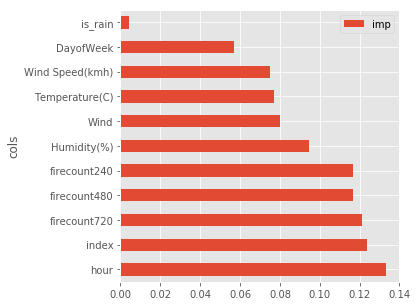

In [29]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,5))

The R-squared is very low, and the model put lots of emphasis on the traffic index. 

# TPOT

In [30]:
from tpot import TPOTRegressor

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [31]:
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_trn, y_trn)
print(tpot.score(X_val, y_val))
tpot.export('tpot_pipeline_PM25diff.py')

Generation 1 - Current best internal CV score: -25.18495361047797
Generation 2 - Current best internal CV score: -25.151294726990756
Generation 3 - Current best internal CV score: -25.142882127310905
Generation 4 - Current best internal CV score: -25.142882127310905
Generation 5 - Current best internal CV score: -25.120097011432556

Best pipeline: XGBRegressor(DecisionTreeRegressor(input_matrix, max_depth=3, min_samples_leaf=12, min_samples_split=7), learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=100, nthread=1, subsample=0.35000000000000003)
-11.011006232946052


Implement TPOT suggested pipeline

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeRegressor
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor

In [34]:
#print score print out rmse, and r2 score
def print_score(m):
    res = [mean_squared_error(m.predict(X_trn), y_trn), mean_squared_error(m.predict(X_val), y_val),
                m.score(X_trn, y_trn), m.score(X_val, y_val)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [35]:
# Average CV score on the training set was:-25.120097011432556
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=3, min_samples_leaf=12, min_samples_split=7)),
    XGBRegressor(learning_rate=0.01, max_depth=10, min_child_weight=6, n_estimators=100, nthread=1, subsample=0.35000000000000003)
)


In [36]:
exported_pipeline.fit(X_trn, y_trn)
results = print_score(exported_pipeline)

[22.1553947772327, 11.011006232946052, 0.1294306175251566, 0.03739798015174234]


In [37]:
# custom made feature of importance based on permutation method
def feat_importance(m, x_trn, y_trn, metric=accuracy_score):
    """ Computes the feature importance for any model
    m is the model
    x_trn is the training data
    metric is the accuracy_score
    """
    baseline = metric(y_trn, m.predict(x_trn))
    imp = []
    imp_std = []
    for col in x_trn.columns:
        tempt = x_trn.copy()
        shuffle = []
        # ten iteration to get better statistic
        for i in range(10):
            tempt[col] = np.random.RandomState(seed=42).permutation(tempt[col])
            shuffle_score = metric(y_trn, m.predict(tempt))
            shuffle.append(-(baseline - shuffle_score)/baseline)
        imp.append(np.mean(shuffle))
        imp_std.append(np.std(shuffle))
    fea_imp = pd.DataFrame({'cols': x_trn.columns, 'imp':imp,'imp_std':imp_std})
    return fea_imp.sort_values('imp', ascending=False)

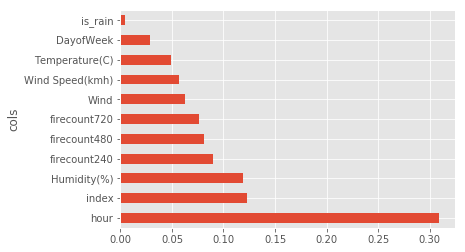

In [38]:
#Calculate feature of importance
fi_per = feat_importance(exported_pipeline, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()
fi_per.plot('cols', 'imp', 'barh', legend=False)